In [6]:
# Imports
import numpy as np
import random

import copy
import torch
from typing import Callable, Optional
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.transforms import Transform
from torch.distributions import constraints
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.flows.spline import NSF
from zuko.flows import UnconditionalDistribution
from zuko.transforms import MonotonicRQSTransform
from zuko.distributions import DiagNormal
from causalflows.flows import CausalFlow
from sklearn.model_selection import KFold

from BD import DGP, policy, new_policy
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

In [71]:
"""
Implements Algorithm 1 and Algorithm 2 from "Causal Normalizing Flows: From Theory to Practice,
    Adrian Javaloy, Pablo Sanchez-Martin, Isabel Valera, (2024)", generalized to transformation
    interventions
"""
def sample_do(
    flow: CausalFlow,
    index: int,
    intervention_fn: Callable[[torch.Tensor], torch.Tensor],
    sample_shape: torch.Size = torch.Size([1]),
) -> torch.Tensor:
    """
    Algorithm 1 (streamlined):
      1) sample z ~ p(z)           (base)
      2) x = f^{-1}(z)              (decode)
      3) new_i = intervention_fn(x[..., index])
      4) x_mod = x with x_mod[...,index]=new_i
      5) z_mod = f(x_mod)           (encode)
      6) z_prime = z; z_prime[...,index]=z_mod[...,index]
      7) x_do = f^{-1}(z_prime)     (decode)
    """
    # 1) & 2)
    dist = flow()                              # NormalizingFlow p(X|context)
    z = dist.base.sample(sample_shape)                # sample latent
    x = dist.transform.inv(z)                     # decode to data

    # 3) compute new intervention values
    old_i = x[..., index]
    new_i = intervention_fn(old_i)

    # 4) form the modified data batch
    x_mod = x.clone()
    x_mod[..., index] = new_i

    # 5) re-encode only the intervened batch
    z_mod = dist.transform(x_mod)

    # 6) splice in the new latent for feature `index`
    z_prime = z.clone()
    z_prime[..., index] = z_mod[..., index]

    # 7) decode the fully downstream‐consistent do‐sample
    x_do = dist.transform.inv(z_prime)
    return x_do

def sample_cf(
    flow: CausalFlow,
    x_obs: torch.Tensor,
    index: int,
    intervention_fn: Callable[[torch.Tensor], torch.Tensor],
) -> torch.Tensor:
    """
    Algorithm 2: compute counterfactual X_cf given factual x_obs under do(X[index] = intervention_fn).

    Args:
        flow: a fitted CausalFlow instance
        x_obs: factual observations, shape (batch, d)
        context: tensor of shape (batch, c_dim) or None if unconditional
        index: which feature to intervene on
        intervention_fn: a function f(old_vals) -> new_vals

    Returns:
        Counterfactuals, shape (batch, d)
    """
    # 1) compute the per-example new value
    orig = x_obs[:, index]                    # shape = (batch,)
    new  = intervention_fn(orig)              # same shape

    # 2) use built‐in CF helper
    return flow().compute_counterfactual(
        x_obs,
        index=index,
        value=new,
    )

def select_and_train_flow(
    flows: list,
    X: torch.Tensor,
    train_fraction: float = 0.8,
    k_folds: int = 5,
    num_epochs: int = 50,
    batch_size: int = 64,
    lr: float = 1e-3,
    device: torch.device = None,
    ):
    """
    1) Split X into train/test
    2) For each flow in `flows`:
         • run k-fold CV on train set, computing mean held-out NLL
    3) Pick best flow (min mean NLL), fresh deepcopy its prototype
    4) Train that best flow on *all* of X (num_epochs, batch_size)
    5) Return (trained_flow, test_nll)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    N, d = X.shape
    # 1) train/test split
    perm = torch.randperm(N)
    n_train = int(train_fraction * N)
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    X_train, X_test = X[train_idx], X[test_idx]
    
    # helper to compute NLL on a dataset
    def eval_nll(model, X_eval):
        model.eval()
        total = 0.0
        count = 0
        with torch.no_grad():
                dist = model()
                nll = -dist.log_prob(X_eval).mean().item()
        return nll  # average NLL per example
    
    # 2) CV on train set
    kf = KFold(n_splits=k_folds, shuffle=True)
    cv_scores = []
    
    for proto in flows:
        scores = []
        for train_f, val_f in kf.split(X_train):
            # fresh copy of the prototype
            model = copy.deepcopy(proto).to(device)
            model.train()
            # DataLoaders for this fold
            ds_tr = TensorDataset(X_train[train_f])
            ds_val = X_train[val_f]
            loader_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
    
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
            # train on this fold
            for _ in range(num_epochs):
                for (x_b,) in loader_tr:
                    x_b = x_b.to(device)
                    dist = model()
                    loss = -dist.log_prob(x_b).mean()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
            # evaluate on the val fold
            nll_val = eval_nll(model, ds_val.to(device))
            scores.append(nll_val)
    
        cv_scores.append(sum(scores)/len(scores))
    
    # 3) pick best
    best_idx = int(torch.argmin(torch.tensor(cv_scores)))
    best_proto = flows[best_idx]
    
    # 4) retrain on *all* X
    best_flow = copy.deepcopy(best_proto).to(device)
    best_flow.train()
    ds_all = TensorDataset(X)
    loader_all = DataLoader(ds_all, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(best_flow.parameters(), lr=lr)
    for _ in range(num_epochs):
        for (x_b,) in loader_all:
            x_b = x_b.to(device)
            dist = best_flow()
            loss = -dist.log_prob(x_b).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
    
    # 5) final test evaluation
    if train_fraction < 1.0:
        test_nll = eval_nll(best_flow, X_test.to(device))
    else:
        test_nll = None
    
    return best_flow, test_nll, best_idx, cv_scores

class ShiftTransform(Transform):
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, b):
        # b will be a tensor of shape (batch,1)
        super().__init__(cache_size=0)
        self.b = b

    def _call(self, x):
        # x: (B,), b: (B,1) ⇒ squeeze to (B,)
        shift = self.b.squeeze(-1)
        return x + shift

    def _inverse(self, y):
        shift = self.b.squeeze(-1)
        return y - shift

    def log_abs_det_jacobian(self, x, y):
        # d(x+shift)/dx = 1  ⇒ log|1| = 0
        return torch.zeros_like(x)

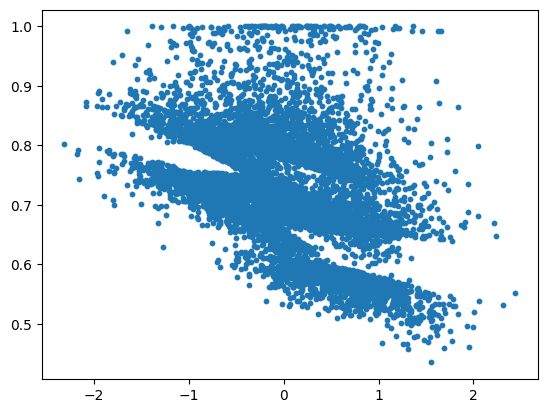

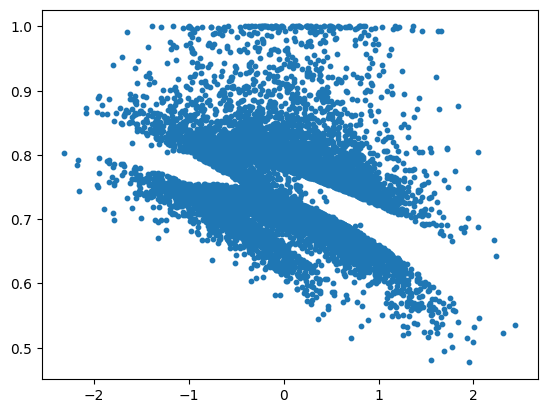

In [7]:
"""
Dataset generation
"""
# Generating observatioanl data with configs
seed = 0
N = int(dgp_config['N']/2)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
Z1,X1,Y1 = Z[:N], X[:N],Y[:N]
Z2,X2,Y2 = Z[N:], X[N:],Y[N:]
plt.scatter(Z @ dgp_config['projection_coeffs'],torch.sigmoid(Y), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
Zint1,Xint1,Yint1 = Zint[:N], Xint[:N],Yint[:N]
Zint2,Xint2,Yint2 = Zint[N:], Xint[N:],Yint[N:]
plt.scatter(Zint @ dgp_config['projection_coeffs'],torch.sigmoid(Yint), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Ztr,Xtr,Ytr = Z[id],X[id],Y[id]

In [172]:
"""
Defining list of flows to CV over
"""
from torch.distributions import Normal, Laplace, StudentT, Independent
from torch import nn
import torch.nn.functional as F

# shared base distribution
base = UnconditionalDistribution(
    Laplace,
    loc=torch.zeros(12),
    scale=torch.ones(12),
    buffer=True,
)

class LearnableStudentT(nn.Module):
    def __init__(self, dim, init_df=3.0, min_df=1e-2):
        super().__init__()
        # raw parameters, unconstrained
        self.raw_df    = nn.Parameter(torch.log(torch.tensor(init_df)))
        self.raw_loc   = nn.Parameter(torch.zeros(dim))
        self.raw_scale = nn.Parameter(torch.zeros(dim))
        self.min_df    = min_df

    def forward(self, c=None):
        # softplus ensures positivity but grows more gently than exp
        df    = F.softplus(self.raw_df) + self.min_df
        scale = F.softplus(self.raw_scale)
        loc   = self.raw_loc

        # build independent Student‑T
        base = StudentT(df=df, loc=loc, scale=scale)
        return Independent(base, 1)

        
# then in your flow setup:
base = LearnableStudentT(
    dim = 12,
    init_df = torch.ones(12)*3
)

# 1) MAF only, shift neural‑net conditioner
maf_nn_shift_only = MaskedAutoregressiveTransform(
    features=12,
    context=0,
    hidden_features=(128, 128),   # you can also use () for purely linear shift
    univariate=ShiftTransform,  # use our shift‐only bijector
    shapes=([1],),              # one shift‐parameter per dimension
)
flow_nn_shift_only = CausalFlow(
    transform=[maf_nn_shift_only],
    base=base,
)

# 2) MAF only, neural‑net conditioner
maf_nn = MaskedAutoregressiveTransform(
    features=12,
    context=0,
    hidden_features=(128, 128),  # two hidden layers of size 32
)
flow_maf_nn = CausalFlow(transform=[maf_nn], base=base)

# 3) MAF → RQS, both neural‑net conditioners
maf_nn = MaskedAutoregressiveTransform(
    features=12,
    context=0,
    hidden_features=(128, 128),
)
rqs_nn = MaskedAutoregressiveTransform(
    features=12,
    context=0,
    hidden_features=(128, 128),
    univariate=MonotonicRQSTransform,
    shapes=([8], [8], [9]),
)
flow_maf_rqs_nn = CausalFlow(transform=[maf_nn, rqs_nn], base=base)

# Print summaries
print("1) MAF shift NN:",    flow_nn_shift_only)
print("2) MAF NN:",          flow_maf_nn)
print("3) MAF+RQS NN:",      flow_maf_rqs_nn)


1) MAF shift NN: CausalFlow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): ShiftTransform()
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=12, bias=True)
      )
    )
  )
  (base): LearnableStudentT()
)
2) MAF NN: CausalFlow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=24, bias=True)
    

/tmp/ipykernel_1650491/2005799057.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.raw_df    = nn.Parameter(torch.log(torch.tensor(init_df)))


In [173]:
"""
Doing CV over flows and optimizing best flow
"""
XY = torch.cat([Z,X[:,:1],Y],dim = 1)
flows = [
    flow_nn_shift_only,
    flow_maf_nn,
    flow_maf_rqs_nn
        ]

flow, testnll, bestidx, cv_scores = select_and_train_flow(
    flows,
    XY,
    train_fraction = 1.0,
    k_folds = 2,
    num_epochs = 100,
    batch_size = 64,
    lr = 1e-3
)
print(bestidx)

2


In [218]:
dist = flow()                              # NormalizingFlow p(X|context)
z = dist.base.sample((10000,))                # sample latent
x = dist.transform.inv(z)   

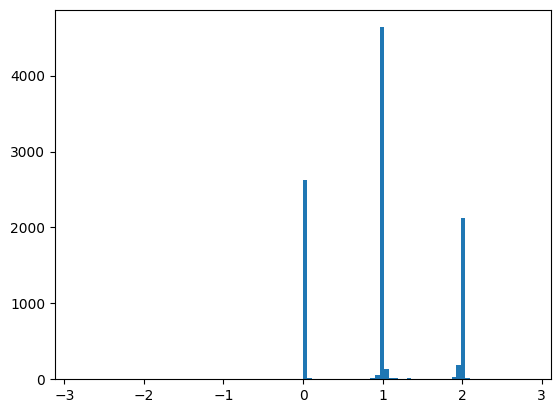

In [219]:
plt.hist(x[:,-2].detach(), bins = 100);

In [239]:
# assume `flow` is your trained CausalFlow, and `c_star` your context (or None)
# intervene “set feature 0 to constant 2.5” for 64 samples:
with torch.no_grad():
    X_do = sample_do(
        flow,
        index=10,
        intervention_fn=lambda old:  old - (old >= 1.5).float(),
        sample_shape=torch.Size([10000]),
    ) 
    # for counterfactuals of some observed batch x_obs:
    X_cf = sample_cf(
        flow,
        XY,                       # shape (batch, d)
        index=10,
        intervention_fn=lambda old: old - (old >= 1.5).float(),  # e.g. add +1 to the factual value
    )

In [240]:
X_do - X_do2

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

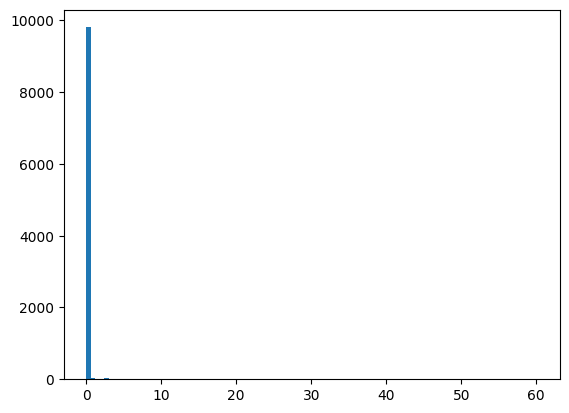

In [233]:
import matplotlib.pyplot as plt
plt.hist(torch.log(1+torch.exp(-X_do[:,-1].detach())), bins = 100);

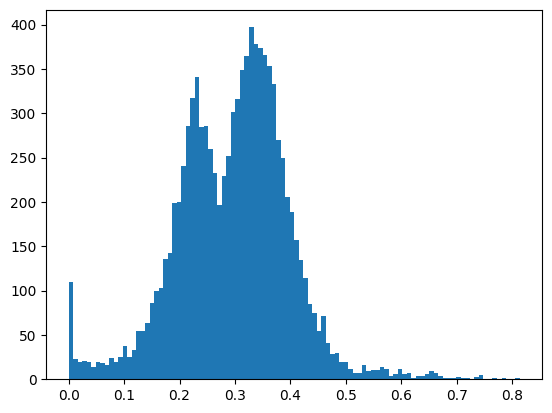

In [234]:
plt.hist(torch.log(1+torch.exp(-X_cf[:,-1].detach())), bins = 100);

In [235]:
Yintpred = X_do[:,-1:]
Ycfpred = X_cf[:,-1:]
Ycfpred[torch.isnan(Ycfpred)] = 10**10

def feature(x):
    return torch.log(1+torch.exp(-x))

counterfactual_diffs = feature(Yint[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds = feature(Ycfpred[X[:,0]==2])-feature(Y[X[:,0]==2])

def kolmogorov_distance(a: torch.Tensor, b: torch.Tensor) -> float:
    a = a.flatten(); b = b.flatten()
    a_s, _ = torch.sort(a); b_s, _ = torch.sort(b)
    all_vs = torch.cat([a_s, b_s]).unique()
    cdf_a = torch.bucketize(all_vs, a_s, right=True).float() / a_s.numel()
    cdf_b = torch.bucketize(all_vs, b_s, right=True).float() / b_s.numel()
    return (torch.abs(cdf_a - cdf_b).max()).item()

# Constructing KSD
KSD = kolmogorov_distance(counterfactual_diffs,counterfactual_diffpreds)
KSDint = kolmogorov_distance(Yintpred,Yint)
CFRMSE = ((counterfactual_diffpreds - counterfactual_diffs)**2).mean().sqrt()

In [236]:
KSD, KSDint, CFRMSE

(0.22191458940505981, 0.03540003299713135, tensor(0.0625))